<a href="https://colab.research.google.com/github/PROFOUNDIVE/AIDHellCamp2/blob/dev3/baseline_code2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6공학관 층 분류하기 - AID 지옥캠프2

- 작성된 환경: Window 11, Pip, Python 3.9, CUDA 11.8, VScode
- Google Colab 등의 클라우드 컴퓨팅 환경에서는 다른 동작을 할 가능성 있음

## 실행 전 사전 준비

### 모듈
- shell에서
``` shell
# Colab 환경은 필요한 모든 모듈이 설치되어 있어 설치할 필요 x
```
``` shell
# 본인 GPU(CUDA)에 맞는 버전을 설치해주세요
# 참고: https://pytorch.org/get-started/locally/
# ex1) Pip, CPU 환경
# pip3 install torch torchvision torchaudio
# ex2) Conda, CUDA 12.4 환경
# conda install pytorch torchvision torchaudio pytorch-cuda=12.4 -c pytorch -c nvidia
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
```
```shell
pip3 install -U scikit-learn
pip3 install -U matplotlib
pip3 install tqdm
```

### 데이터 파일
- 데이터 파일을 root 경로(baseline_code.ipynb가 있는 폴더)에 압축해제 해주세요
- data link: https://www.kaggle.com/datasets/hyunseok21/jiokdata
- colab 환경이라면 다음 [챕터](#colab-환경에서-kaggle파일-다운로드하기---로컬환경이라면-건너뛰기) 확인해주세요
``` shell
📁root
 ├─📁test
 ├─📁train
 │  ├─📁2F_train
 │  ├─📁3F_train
 │  ├─📁4F_train
 │  └─📁5F_train
 └─📜baseline_code.ipynb
```

#### Colab 환경에서 kaggle파일 다운로드하기 - **로컬환경이라면 건너뛰기**

In [54]:
# 실행 시 업로드 버튼 활성화
# kaggle에서 발급받은 api key가 담긴 json 파일 업로드
COLAB = True
try:
  from google.colab import files
  files.upload()
except:
  COLAB = False

Saving kaggle.json to kaggle (1).json


In [55]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [57]:
if COLAB:
  import kagglehub
  import shutil

  # Download latest version
  path = kagglehub.dataset_download("hyunseok21/jiokdata")

  print("Path to dataset files:", path)
  shutil.move(path+'/jiokdata/train', '/content/')
  shutil.move(path+'/jiokdata/test', '/content/')

Path to dataset files: /root/.cache/kagglehub/datasets/hyunseok21/jiokdata/versions/1


Error: Destination path '/content/train' already exists

## EfficientNet pre-trained model 불러오기

In [58]:
!pip install validators matplotlib

In [59]:
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [60]:
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

efficientnet.eval().to(device)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
      

### Example of inference

In [61]:
uris = [
    'http://images.cocodataset.org/test-stuff2017/000000024309.jpg',
    'http://images.cocodataset.org/test-stuff2017/000000028117.jpg',
    'http://images.cocodataset.org/test-stuff2017/000000006149.jpg',
    'http://images.cocodataset.org/test-stuff2017/000000004954.jpg',
]

batch = torch.cat(
    [utils.prepare_input_from_uri(uri) for uri in uris]
).to(device)

In [62]:
with torch.no_grad():
    output = torch.nn.functional.softmax(efficientnet(batch), dim=1)

results = utils.pick_n_best(predictions=output, n=5)

sample 0: [('laptop, laptop computer', '49.9%'), ('notebook, notebook computer', '36.2%'), ('desk', '3.7%'), ('mouse, computer mouse', '0.5%'), ('space bar', '0.5%')]
sample 1: [('mashed potato', '87.0%'), ('meat loaf, meatloaf', '5.2%'), ('broccoli', '1.9%'), ('plate', '0.3%'), ('guacamole', '0.1%')]
sample 2: [('racket, racquet', '55.8%'), ('tennis ball', '8.4%'), ('ping-pong ball', '2.6%'), ('golf ball', '0.6%'), ('baseball', '0.6%')]
sample 3: [('kelpie', '52.7%'), ('malinois', '4.1%'), ('groenendael', '3.0%'), ('schipperke', '3.0%'), ('Scottish deerhound, deerhound', '2.6%')]


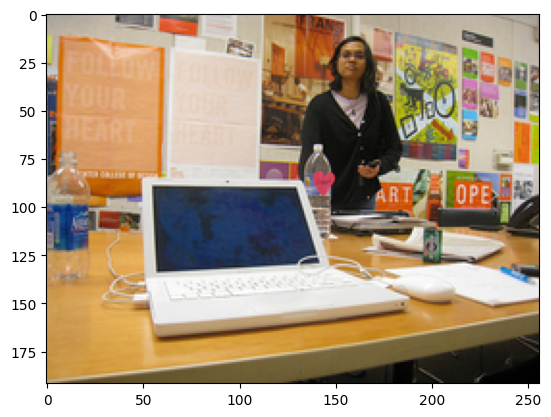

[('laptop, laptop computer', '49.9%'), ('notebook, notebook computer', '36.2%'), ('desk', '3.7%'), ('mouse, computer mouse', '0.5%'), ('space bar', '0.5%')]


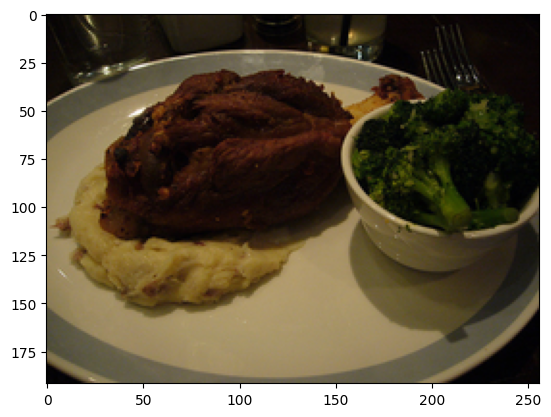

[('mashed potato', '87.0%'), ('meat loaf, meatloaf', '5.2%'), ('broccoli', '1.9%'), ('plate', '0.3%'), ('guacamole', '0.1%')]


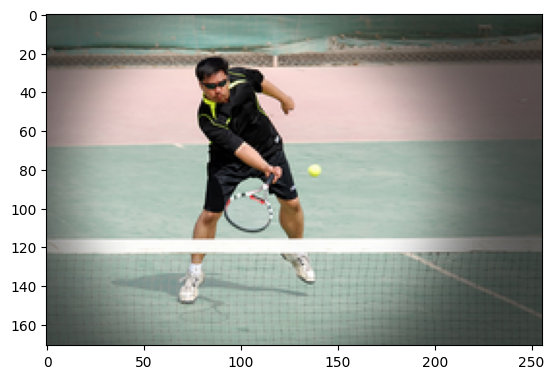

[('racket, racquet', '55.8%'), ('tennis ball', '8.4%'), ('ping-pong ball', '2.6%'), ('golf ball', '0.6%'), ('baseball', '0.6%')]


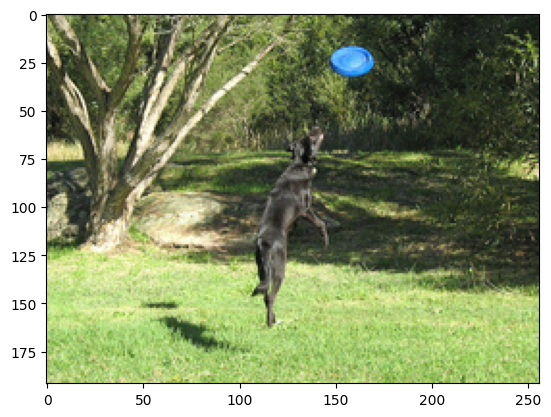

[('kelpie', '52.7%'), ('malinois', '4.1%'), ('groenendael', '3.0%'), ('schipperke', '3.0%'), ('Scottish deerhound, deerhound', '2.6%')]


In [63]:
for uri, result in zip(uris, results):
    img = Image.open(requests.get(uri, stream=True).raw)
    img.thumbnail((256,256), Image.Resampling.LANCZOS)
    plt.imshow(img)
    plt.show()
    print(result)

In [64]:
!pip install efficientnet_pytorch

# Train Data로 학습하기

## 모델 학습 (with train data)

### 모듈 불러오기

In [65]:
import time
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

### CUDA 코어 테스트 & 할당

In [66]:
if torch.cuda.is_available():
  print(torch.cuda.get_device_name())
  print(torch.__version__)
  print(torch.version.cuda)
  x = torch.randn(1).cuda()
  print(x)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

Tesla T4
2.5.1+cu121
12.1
tensor([0.6328], device='cuda:0')


device(type='cuda', index=0)

### 하이퍼 파라미터 (Hyper Parameter)

In [67]:
params = {
  # For Train
  'epoch': 10,
  'batch_size': 16,

  # CPU worker
  'workers': 4, # 본인 cpu 쓰레드의 절반 정도

  # imgShow
  'num_show_img': 5, # 데이터가 잘 로드 되었는지 확인 하는 셀에서 보여줄 데이터 개수, 학습과 관련 없음

  # For Optimizer
  'learning_rate': 0.001,
}

### 저장할 학습 완료 모델 파일 이름

In [68]:
pt_file_name = 'model.pt'

### 데이터 라벨링

In [69]:
class_names = {
  "0": "2F",
  "1": "3F",
  "2": "4F",
  "3": "5F",
}

### 데이터 전처리

In [70]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# 1. 데이터 전처리 정의
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 2. 데이터 로드
dataset = datasets.ImageFolder(root='./train', transform=train_transforms)

# 3. 데이터셋 분리
train_idx, tmp_idx = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)
data_sets = {}
data_sets['train'] = Subset(dataset, train_idx)

# Valid/Test 데이터 나누기
val_idx, test_idx = train_test_split(tmp_idx, test_size=0.5, random_state=42)
data_sets['valid'] = Subset(dataset, val_idx)
data_sets['test'] = Subset(dataset, test_idx)

# 4. DataLoader 정의
dataloaders = {
    'train': DataLoader(data_sets['train'], batch_size=32, shuffle=True, num_workers=4, pin_memory=True),
    'valid': DataLoader(data_sets['valid'], batch_size=32, shuffle=False, num_workers=4, pin_memory=True),
    'test': DataLoader(data_sets['test'], batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
}

### Train 함수
**입력 인자:**

model: 학습시킬 PyTorch 모델.  
criterion: 손실 함수 (예: nn.CrossEntropyLoss).
optimizer: 모델의 파라미터를 업데이트할 옵티마이저 (예: torch.optim.Adam).  
dataloaders: train과 valid 데이터를 로드하는 DataLoader 딕셔너리.  
num_epochs: 학습 에포크 수 (기본값: 25).

**출력값:**

model: 최종 학습 완료된 모델.  
best_idx: 가장 높은 검증 정확도를 기록한 에포크 번호.  
best_acc: 가장 높은 검증 정확도.  
train_loss, train_acc: 학습 손실 및 정확도의 기록.  
valid_loss, valid_acc: 검증 손실 및 정확도의 기록.

In [71]:
def train_model(model, criterion, optimizer, dataloaders: dict, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict()) # 가장 높은 검증 정확도를 기록한 모델의 가중치를 저장
  best_acc = 0.0
  train_loss, train_acc, valid_loss, valid_acc = [], [], [], []

  for epoch in range(num_epochs): # 에포크(epoch) 단위로 학습을 반복
    print()
    print('Epoch {}/{}'.format(epoch+1, num_epochs), end=": ")
    print('-'*10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'valid']:
      if phase =='train':
        model.train() # Set model to training mode
      else:
        model.eval() # Set model to evaluate mode

      running_loss, running_corrects, num_cnt = 0.0, 0, 0

      count = 1

      #Iterate over data.
      pbar_dataloaders = tqdm(dataloaders[phase],
                              desc=phase,
                              ncols=70)
      for inputs, labels in pbar_dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad() # 이전 배치에서 계산된 그라디언트를 초기화

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs) # 모델에 입력 데이터를 전달해 출력(logits)을 계산
          _, preds = torch.max(outputs, 1) # 출력 logits에서 가장 높은 값을 가진 클래스 예측
          loss = criterion(outputs, labels) # 손실 함수(예: 크로스 엔트로피)를 사용해 손실 계산

          # backward only if in training phase
          if phase == 'train':
            loss.backward() # 그라디언트를 역전파(backpropagation)로 계산
            optimizer.step() # 모델의 파라미터를 업데이트

        # statistics
        running_loss += loss.item() * inputs.size(0) # 손실 값을 배치 크기만큼 누적
        running_corrects += torch.sum(preds == labels.data) # 올바르게 예측한 샘플 수를 누적
        num_cnt += len(labels) # 처리한 샘플 수(num_cnt) 누적
        count += 1
      pbar_dataloaders.close()

      # 현재 에포크에서의 평균 손실과 정확도를 계산
      epoch_loss = float(running_loss / num_cnt)
      epoch_acc = float((running_corrects.double() / num_cnt).cpu()*100)

      if phase == 'train':
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
      else:
        valid_loss.append(epoch_loss)
        valid_acc.append(epoch_acc)
      print()
      print(f'{phase} Loss: {epoch_loss:.2f} Acc: {epoch_acc:.1f}')

      # deep copy the model (최고 성능 모델 저장)
      if phase == 'valid' and epoch_acc > best_acc:
        best_idx = epoch + 1
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

  # 최종 결과
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print('Best valid Acc: idx=%d , %.1f'%(best_idx, best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  torch.save(model.state_dict(), pt_file_name)
  print('model saved')
  return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

### 모델 구성

In [72]:
class BaseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=1, stride=1, padding=0)

        self.fc1 = nn.Linear(4 * 224 * 224, 8)
        self.fc2 = nn.Linear(8, 4)

    def forward(self, x):
        # Weak activation with minimal learning capacity
        x = F.sigmoid(self.conv1(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x


### 데이터 불러오기

- 과적합 방지, 정확도 상승을 위해 torch.transforms 활용하여 데이터 증강 & 변형 시도 추천

In [73]:
data_path = './train'
train = datasets.ImageFolder(
                      data_path,
                      transforms.Compose([
                        transforms.Resize((224, 224)), # 이미지 224x224로 맞추기
                        transforms.ToTensor(), # 텐서화
                      ]))

### 데이터를 Train:Valid:Test=8:1:1로 나누기

In [12]:
# # train : valid : test = 8 : 1 : 1
# train_idx, tmp_idx = train_test_split(list(range(len(train))), test_size=0.2)
# data_sets = {}
# data_sets['train'] = Subset(train, train_idx)
# tmp_dataset = Subset(train, tmp_idx)

# val_idx, test_idx = train_test_split(list(range(len(tmp_dataset))), test_size=0.5)
# data_sets['valid'] = Subset(tmp_dataset, val_idx)
# data_sets['test'] = Subset(tmp_dataset, test_idx)

### 데이터 로더 정의 & 사이즈 확인

In [13]:
# data loader
dataloaders, batch_num = {}, {}
dataloaders['train'] = DataLoader(data_sets['train'],
                                  batch_size=params['batch_size'],
                                  shuffle=True,
                                  num_workers=params['workers'])
dataloaders['valid'] = DataLoader(data_sets['valid'],
                                  batch_size=params['batch_size'],
                                  shuffle=False,
                                  num_workers=params['workers'])
dataloaders['test'] = DataLoader(data_sets['test'],
                                  batch_size=params['batch_size'],
                                  shuffle=False,
                                  num_workers=params['workers'])
batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size: %d,  train / valid / test: %d / %d / %d' % (params['batch_size'], batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size: 16,  train / valid / test: 361 / 46 / 46


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### 데이터 확인

In [14]:
def imgShow(input, title=None):
  """Img show for Tensor."""
  input = input.numpy().transpose((1,2,0))
  input = np.clip(input, 0, 1)
  plt.imshow(input)
  if title is not None:
    plt.title(title)
  plt.pause(0.001) # pause a bit so that plots are updated

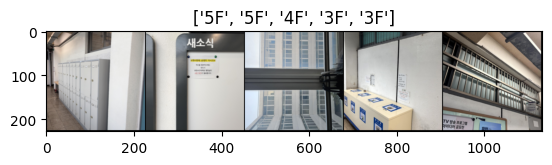

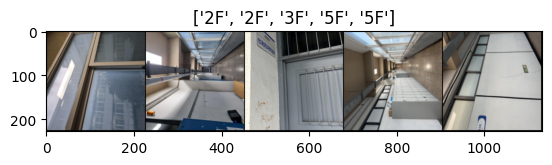

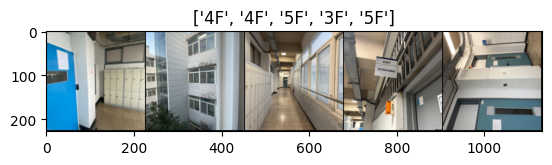

In [15]:
# train data
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:params['num_show_img']])
imgShow(out, title=[class_names[str(int(x))] for x in classes[:params['num_show_img']]])
# valid data
inputs, classes = next(iter(dataloaders['valid']))
out = torchvision.utils.make_grid(inputs[:params['num_show_img']])
imgShow(out, title=[class_names[str(int(x))] for x in classes[:params['num_show_img']]])
# test data
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs[:params['num_show_img']])
imgShow(out, title=[class_names[str(int(x))] for x in classes[:params['num_show_img']]])

### 모델을 장치로 할당

In [74]:
model = BaseModel()

# setting
model = model.to(device)

# CUDA 확인
if next(model.parameters()).is_cuda:
  print("Model to CUDA")
else:
  print("Model to CPU")

TypeError: EfficientNet.forward() missing 1 required positional argument: 'x'

### 손실함수 & 옵티마이저

In [17]:
# 손실함수
criterion = torch.nn.CrossEntropyLoss()

# 옵티마이저
optimizer = torch.optim.SGD(model.parameters(),
                            lr=params['learning_rate'],
                          )

### 학습 시작

In [18]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer, dataloaders, num_epochs=params['epoch'])


Epoch 1/2: ----------


train: 100%|████████████████████████| 361/361 [09:35<00:00,  1.59s/it]



train Loss: 1.39 Acc: 25.3


valid: 100%|██████████████████████████| 46/46 [01:13<00:00,  1.59s/it]



valid Loss: 1.38 Acc: 27.2
==> best model saved - 1 / 27.2

Epoch 2/2: ----------


train: 100%|████████████████████████| 361/361 [09:43<00:00,  1.62s/it]



train Loss: 1.39 Acc: 26.1


valid: 100%|██████████████████████████| 46/46 [01:12<00:00,  1.57s/it]


valid Loss: 1.39 Acc: 27.2
Training complete in 21m 45s
Best valid Acc: idx=1 , 27.2
model saved


## 학습 결과 분석

best model info:
Model extracted from epoch 1
Valid Acc=27 / Valid Loss=1.4


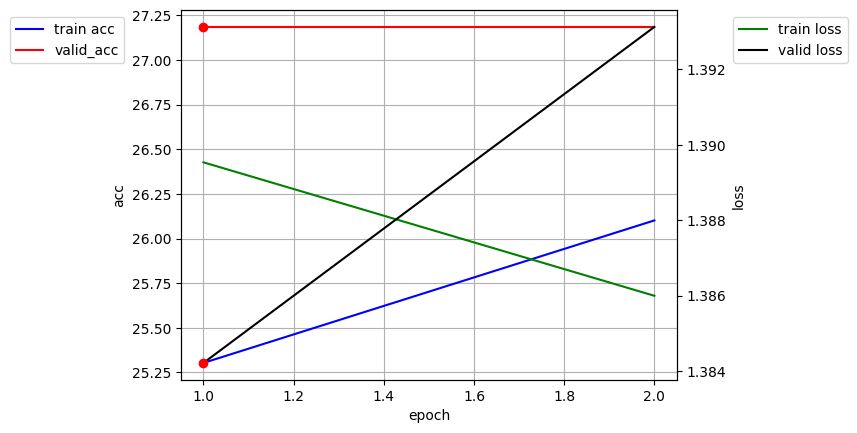

In [19]:
## 결과 그래프 그리기
print('best model info:\nModel extracted from epoch %d\nValid Acc=%1.f / Valid Loss=%.1f'%(best_idx, valid_acc[best_idx-1], valid_loss[best_idx-1]))
fig, ax1 = plt.subplots()

ax1.plot([n for n in range(1,len(train_acc)+1)], train_acc, 'b-', label='train acc')
ax1.plot([n for n in range(1,len(valid_acc)+1)], valid_acc, 'r-', label ='valid_acc')
plt.plot(best_idx, valid_acc[best_idx-1], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')
plt.legend(bbox_to_anchor=(-0.1, 1.0), loc="upper right")
plt.grid()

ax2 = ax1.twinx()
ax2.plot([n for n in range(1,len(train_loss)+1)], train_loss, 'g-', label='train loss')
ax2.plot([n for n in range(1,len(valid_loss)+1)], valid_loss, 'k-', label='valid loss')
plt.plot(best_idx, valid_loss[best_idx-1], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')
plt.legend(bbox_to_anchor=(1.1, 1.0), loc="upper left")


plt.show()

## 모델 TEST

In [20]:
def test_and_visualize_model(model, dataloaders, phase = 'test', num_images=4):
  # phase = 'train', 'valid', 'test'

  was_training = model.training
  model.eval()

  running_loss, running_corrects, num_cnt = 0.0, 0, 0

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders[phase]):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels) # batch의 평균 loss 출력

      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
      num_cnt += inputs.size(0) # batch size

    test_loss = running_loss / num_cnt
    test_acc = running_corrects.double() / num_cnt
    print('test done : loss/acc : %.2f / %.1f' % (test_loss, test_acc*100))

  # 예시 그림 출력
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders[phase]):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(1, num_images+1):
        ax = plt.subplot(num_images//2, 2, j)
        ax.axis('off')
        ax.set_title('%s : %s -> %s' %(
          'True' if class_names[str(labels[j].cpu().numpy())] == class_names[str(preds[j].cpu().numpy())] else 'False',
          class_names[str(labels[j].cpu().numpy())],
          class_names[str(preds[j].cpu().numpy())]
        ))
        imgShow(inputs.cpu().data[j])

      if i == 0: break

  model.train(mode=was_training) # 다시 train모드로 전환

test done : loss/acc : 1.39 / 27.0


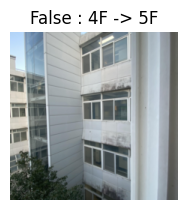

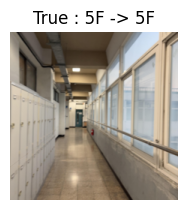

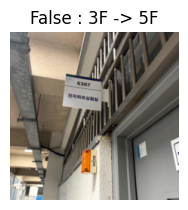

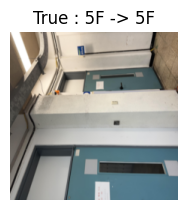

In [21]:
test_and_visualize_model(model, dataloaders, phase='test')

# Test 데이터 분류 및 CSV 만들기

In [22]:
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import sys

In [23]:
data_path = './test'
image_files = sorted(glob.glob(data_path + '/*'))
csv_filename = 'answer.csv'

os_name = sys.platform
path_split = '/'
if os_name.startswith('win'):
  path_split = '\\'

In [24]:
class TestImageDataset(Dataset):
  def __init__(self, files, transform):
    super().__init__()
    self.files = files
    self.transform = transform

  def __len__(self):
    return len(self.files)

  def __getitem__(self, index):
    file = self.files[index]
    try:
        img = Image.open(file).convert('RGB')
    except Exception as e:
        print(f"Error opening image {file}: {e}")
        raise
    img = self.transform(img)

    return img, file.split(path_split)[-1]

In [25]:
test_transform = transforms.Compose([
                        transforms.Resize((224, 224)), # 224x224 사이즈로 변환
                        transforms.ToTensor(), # 텐서화
                      ])

In [26]:
test_dataset = TestImageDataset(image_files, test_transform)

In [27]:
test_loader = DataLoader(test_dataset,
                         batch_size=params['batch_size'],
                         shuffle=False,
                         )

In [28]:
model_dict = torch.load(pt_file_name, map_location=device)
trained_model = BaseModel()
trained_model.load_state_dict(model_dict)
trained_model = trained_model.to(device)

# CUDA 확인
print(f"CUDA:{next(trained_model.parameters()).is_cuda}")

CUDA:True


<ipython-input-28-384f873c373f>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(pt_file_name, map_location=device)


In [29]:
def test_and_make_csv(model, dataloader):
  # phase = 'train', 'valid', 'test'

  model.eval()

  answer_csv = 'id,floor\n'

  pbar_dataloaders = tqdm(dataloader,
                          desc='Making Csv',
                          ncols=70)
  with torch.no_grad():
    for inputs, filenames in pbar_dataloaders:
      inputs = inputs.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(len(preds)):
        answer_csv += f'{filenames[j].split(".")[0]},{class_names[str(preds[j].cpu().numpy())]}\n'
  pbar_dataloaders.close()

  with open(csv_filename, 'w') as file:
    file.write(answer_csv)
    print(f'{csv_filename}가 생성되었습니다.')

In [30]:
test_and_make_csv(trained_model, test_loader)

Making Csv: 100%|█████████████████████| 50/50 [01:31<00:00,  1.83s/it]

answer.csv가 생성되었습니다.
